### Pinchout Example 2
#### Showcasing LoopStructural-Flopy to address Model Structure Uncertainty

This notebook is an extension from 01 Pinchout Example notebook which highlights the relative impact of structural versus paramater uncertainty. It also plots head differences between extreme structural models which indicates area of particular hydraulic uncertainty.

### 1. Project parameters

In [1]:
%run ./loop_showcase_functions.ipynb
#load from MODFLOW_tools (clone repo https://github.com/JimMcCallum/MODFLOW_Tools)
%run ../../MODFLOW_Tools/modelling_routines/modelling_routines.ipynb
%run ../../MODFLOW_Tools/meshing_routines/meshing_routines.ipynb
%run ../../MODFLOW_Tools/geomodel_routines/geomodel_routines.ipynb
%run ../../MODFLOW_Tools/loop2flopy/loop2flopy.ipynb
%run ../../MODFLOW_Tools/plotting_routines_USG/plotting_routines.ipynb

C:\Users\19904604\AppData\Local\Temp\ipykernel_17532\3209728366.py:21: DeprecationWarning: GeoPandas is set to use PyGEOS over Shapely. PyGEOS support is deprecatedand will be removed in GeoPandas 1.0, released in the Q1 of 2024. Please migrate to Shapely 2.0 (https://geopandas.org/en/stable/docs/user_guide/pygeos_to_shapely.html).
  import geopandas as gpd


Modelling routines loaded!
Meshing routines loaded!
Geomodel routines loaded!
loop2flopy routines loaded!
Plotting routines loaded!


In [2]:
P = Project('showcase', boundingbox = [0, 6000, 0, 6000, -500, 0]) # (x0, x1, y0, y1, z0, z1)

# ------------- DISCRETISATION PARAMETERS -----------------------#
P.triExeName = '../exe/triangle.exe'
P.workspace = '../modelfiles/'
P.crs = "epsg:28350" # Put in coordinate reference

P.xypumpbores = [] 
P.idpumpbores = ['P1', 'P2'] 
P.xyobsbores = [(1500,1000), (2500, 5000), (2500, 2500), (5000,5000)] 
P.idobsbores = ['OB1', 'OB2', 'OB3', 'OB4'] 
P.zobs = [-30, -50, -70, -100, -150, -200, -250, -300]
P.nobs = len(P.xyobsbores)
P.npump = len(P.xypumpbores)

P.r = 40        # refining factor for model boundary. High r has refined edges
P.w = 100       # Interior boundary
P.boundmaxtri = 50000 # 8/5 - was 20000
P.modelmaxtri = 50000 # 8/5 - was 30000
P.angle = 32   # minimum triangle angles
P.nlv  = 30    

P.radius1 = 100 # radius of inner circle around pumping bores
P.radius2 = 200 # radius of outer circle around pumping bores
P.boremaxtri = 99999

#P.geo_bores = ['P1', 'P2', 'P3', 'P4']
#P.geo_coords=[(500,500), (1600, 2800), (5500,5500), (2800,1600)]

# ------------- FLOW MODEL PARAMETERS -----------------------#
P.mfexe_name = '../exe/mf6.exe'

P.nlg = 4    # number of geological layers
P.nls = 3 # Number sublayers for conformable

P.ss = [0.0001, 0.00001, 0.0001, 0.0001]
P.rch = 0.4/365 # 0.0027 m/d
P.strt = -20.
P.chfunc = lambda x,z: -(0.005*x) - (z * 0.02)-20 # horizontal gradient of 0.01 and vertical gradient of 0.02
P.xt3d = True

P.hk = [1, 0.1, 10, 0.1] 
P.vk = [i/10 for i in P.hk]

vtk_workspace = '../vtk_files'
if not os.path.isdir(vtk_workspace):
    os.makedirs(vtk_workspace, exist_ok=True)
P.cell2dvor, P.xcycvor, P.verticesvor, P.vor, vornodes = createcell2d(P, grid = 'vor', fault = False)    

### Pinchouts - multiple simulations

In [3]:
data = pd.read_excel("../data/loop_showcase_data.xls",sheet_name = "pinchout_example")
strat = pd.read_excel("../data/loop_showcase_data.xls",sheet_name = "strat")

###### STRUCTURE ########
options = np.linspace(-250, 0, 6) # control point z values
pinchout_modelnames, pinchout_models, pinchout_obs_heads, pinchout_heads = [],[],[],[]   
for i in range(len(options)):
    pinchout_modelnames.append(str('PO_'+str(options[i])))  
    pinchout_models.append(Model(pinchout_modelnames[i], P, plan = 'vor', transect = 'con')) # Create flow model  
    P.control_points = (['CP1', 'control', 3000, 3000, options[i], -200, 'c', 'lower', np.nan, np.nan, np.nan],) 
    P.data, P.strat = prepare_geomodel_loopshowcase(P, data, strat, include_fault = False)   # Prepare geomodel inputs
    P.geomodel = create_geomodel_loopshowcase(P, include_fault = False) # Make geomodel
    M = pinchout_models[i]
    M.create_lith_dis_arrays(P)                                 # Create lith and dis arrays
    M.create_prop_arrays(P)                                     # Create K arrays
    M.create_flow_package_arrays(P)                             # Create flow packages
    M.gwf, M.head_ss, M.obs_ss, M.runtime_ss = M.write_run_model(P, period = 'Steady')   
    pinchout_heads.append(M.head_ss)
    pinchout_obs_heads.append((process_obs(P, M)))

C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\skimage\util\dtype.py:27: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  np.bool8: (False, True),
C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  PO_-250.0  ...
Time taken =  3.513029
Creating property arrays for  PO_-250.0  ...
Time taken =  0.014164
Adding flow packages to  PO_-250.0  ...
Time taken =  3.122465
Writing simulation and gwf for  PO_-250.0  ...
PO_-250.0
Running simulation for  PO_-250.0  ...


Period =  Steady 
Model success =  True
run_time =  35.53778
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  PO_-200.0  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  2.393638
Creating property arrays for  PO_-200.0  ...
Time taken =  0.016086
Adding flow packages to  PO_-200.0  ...
Time taken =  1.573264
Writing simulation and gwf for  PO_-200.0  ...
PO_-200.0
Running simulation for  PO_-200.0  ...


Period =  Steady 
Model success =  True
run_time =  36.363642
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  PO_-150.0  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  2.59729
Creating property arrays for  PO_-150.0  ...
Time taken =  0.02016
Adding flow packages to  PO_-150.0  ...
Time taken =  1.592619
Writing simulation and gwf for  PO_-150.0  ...
PO_-150.0
Running simulation for  PO_-150.0  ...


Period =  Steady 
Model success =  True
run_time =  31.231461
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  PO_-100.0  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  2.501853
Creating property arrays for  PO_-100.0  ...
Time taken =  0.015003
Adding flow packages to  PO_-100.0  ...
Time taken =  1.408077
Writing simulation and gwf for  PO_-100.0  ...
PO_-100.0
Running simulation for  PO_-100.0  ...


Period =  Steady 
Model success =  True
run_time =  27.852265
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  PO_-50.0  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  2.645899
Creating property arrays for  PO_-50.0  ...
Time taken =  0.0
Adding flow packages to  PO_-50.0  ...
Time taken =  1.370884
Writing simulation and gwf for  PO_-50.0  ...
PO_-50.0
Running simulation for  PO_-50.0  ...


Period =  Steady 
Model success =  True
run_time =  29.528119
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  PO_0.0  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  5.459845
Creating property arrays for  PO_0.0  ...
Time taken =  0.018188
Adding flow packages to  PO_0.0  ...
Time taken =  3.120165
Writing simulation and gwf for  PO_0.0  ...
PO_0.0
Running simulation for  PO_0.0  ...
Period =  Steady 
Model success =  True
run_time =  37.973386


In [4]:
###### PARAM ########
P.control_points = (['CP1', 'control', 3000, 3000, -200, -200, 'c', 'lower', np.nan, np.nan, np.nan],) 
P.data, P.strat = prepare_geomodel_loopshowcase(P, data = data, include_fault = False)   # Prepare geomodel inputs
P.geomodel = create_geomodel_loopshowcase(P, include_fault = False) # Make geomodel
        
meanhk = [1, 0.1, 10, 0.1] 
meanvk = [0.1, 0.01, 1, 0.01]
mult = [10]
options = []
for i in range(1):
    for j in range(4):
        for k in range(4):
            hk = np.copy(meanhk)
            hk[j] = hk[j]*mult[i]
            vk = np.copy(meanvk)
            vk[k] = vk[k]*mult[i]
            options.append((hk, vk))
len(options)           

{'upper': 0, 'upper_unconformity': 1, 'lower': 2}


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


16

In [5]:
param_modelnames, param_models, param_obs_heads, param_heads = [], [], [], []
for i in range(len(options)):
    P.hk = options[i][0]
    P.vk = options[i][1]
    print('----------')
    print(P.hk)
    print(P.vk)
    print('----------')
    param_modelnames.append(str('PO_'+str(i)))  
    param_models.append(Model(param_modelnames[i], P, plan = 'vor', transect = 'con')) # Create flow model  
    M = param_models[i]
    M.create_lith_dis_arrays(P)                                 # Create lith and dis arrays
    M.create_prop_arrays(P)                                     # Create K arrays
    M.create_flow_package_arrays(P)                             # Create flow packages
    M.gwf, M.head_ss, M.obs_ss, M.runtime_ss = M.write_run_model(P, period = 'Steady')   
    param_heads.append((M.head_ss))
    param_obs_heads.append((process_obs(P, M)))

----------
[10.   0.1 10.   0.1]
[1.   0.01 1.   0.01]
----------
Creating lithology and discretisation arrays for  PO_0  ...
Time taken =  2.097971
Creating property arrays for  PO_0  ...
Time taken =  0.010224
Adding flow packages to  PO_0  ...
Time taken =  1.168594
Writing simulation and gwf for  PO_0  ...
PO_0
Running simulation for  PO_0  ...
Period =  Steady 
Model success =  True
run_time =  23.760125
----------
[10.   0.1 10.   0.1]
[0.1  0.1  1.   0.01]
----------
Creating lithology and discretisation arrays for  PO_1  ...
Time taken =  1.352246
Creating property arrays for  PO_1  ...
Time taken =  0.0001
Adding flow packages to  PO_1  ...
Time taken =  0.986815
Writing simulation and gwf for  PO_1  ...
PO_1
Running simulation for  PO_1  ...
Period =  Steady 
Model success =  True
run_time =  21.790915
----------
[10.   0.1 10.   0.1]
[ 0.1   0.01 10.    0.01]
----------
Creating lithology and discretisation arrays for  PO_2  ...
Time taken =  1.411497
Creating property array

Running simulation for  PO_15  ...
Period =  Steady 
Model success =  True
run_time =  20.442084


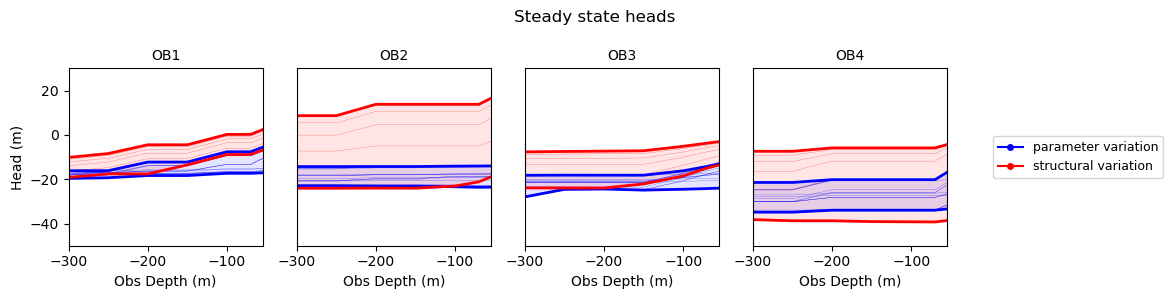

In [6]:
%run ./loop_showcase_functions.ipynb
param_vs_struct(param_obs_heads, pinchout_obs_heads, xlim = [-300, -55], ylim = [-50,30])

C:\Users\19904604\AppData\Local\Temp\ipykernel_30956\398711091.py:6: UserWarning: Warning: converting a masked element to nan.
  if math.isnan(h) == False:


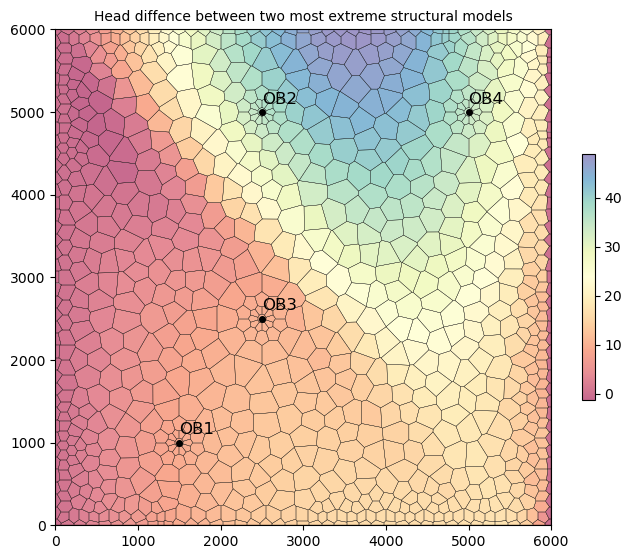

In [7]:
heads_A = find_watertable_disu(P, M = pinchout_models[-1], layer = 2)
heads_B = find_watertable_disu(P, M = pinchout_models[0], layer = 2)
plot_head_diff(P, pinchout_models[0], heads_A, heads_B)

C:\Users\19904604\AppData\Local\Temp\ipykernel_30956\398711091.py:6: UserWarning: Warning: converting a masked element to nan.
  if math.isnan(h) == False:


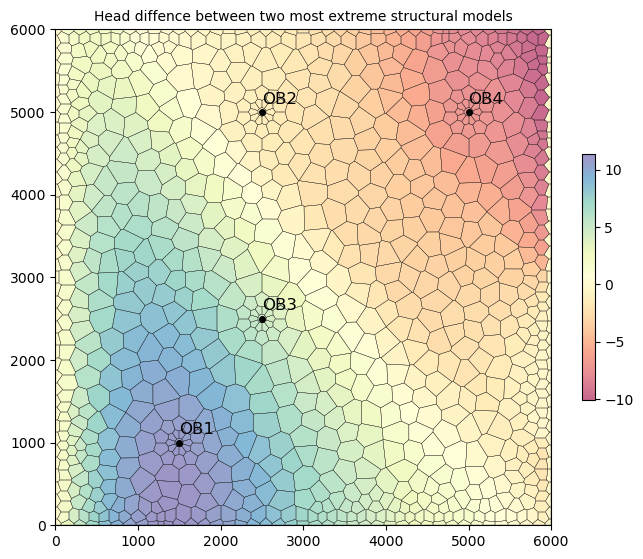

In [8]:
heads_A = find_watertable_disu(P, M = param_models[-1], layer = 2)
heads_B = find_watertable_disu(P, M = param_models[0], layer = 2)
plot_head_diff(P, param_models[0], heads_A, heads_B)

In [9]:
# Plot multiple sims

#multiplot_vgrid_transect(P, models = pinchout_models, array = 'lith', X0 = P.x0, Y0 = P.y0, X1 = P.x1, Y1 = P.y1,)

In [10]:
#multiplot_prop_transect(P, models = pinchout_models, array = 'head_ss', 
#                        X0 = P.x0, Y0 = P.y0, X1 = P.x1, Y1 = P.y1,
#                        vmin = -45, vmax = 10)